In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, RobustScaler,
                                   PowerTransformer, QuantileTransformer, LabelEncoder)
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from persiantools.jdatetime import JalaliDate
from datetime import datetime
import lightgbm as lgb
import re
import warnings
import geopandas as gpd


warnings.filterwarnings('ignore')

In [2]:
divar_df = pd.read_csv('../DataSets/Divar.csv')

In [54]:
df = divar_df.copy()
original_shape = df.shape
print(f"Original dataset: {original_shape[0]:,} rows × {original_shape[1]} columns")

Original dataset: 1,000,000 rows × 61 columns


In [55]:
# Column definitions for real estate domain
target_columns = ['price_value', 'rent_value',
                  'credit_value', 'transformable_price']

boolean_columns = ['rent_to_single', 'has_business_deed', 'has_balcony',
                   'has_elevator', 'has_electricity', 'has_gas', 'has_security_guard',
                   'has_warehouse', 'has_parking', 'is_rebuilt', 'has_water',
                   'has_barbecue', 'has_pool', 'has_jacuzzi', 'has_sauna',
                   'rent_credit_transform', 'transformable_price']


numerical_columns = [
    'rent_value', 'price_value', 'credit_value',
    'transformable_credit', 'transformed_credit', 'transformable_rent', 'transformed_rent',
    'land_size', 'building_size', 'floor', 'rooms_count', 'total_floors_count',
    'unit_per_floor', 'construction_year', 'regular_person_capacity',
    'extra_person_capacity', 'cost_per_extra_person',
    'rent_price_on_regular_days', 'rent_price_on_special_days',
    'rent_price_at_weekends', 'month_created', 'seaseon_created', 'year_created'
]

price_columns = ['price_value', 'rent_value', 'credit_value', 'transformable_price',
                 'transformable_credit', 'transformed_credit', 'transformable_rent',
                 'transformed_rent', 'cost_per_extra_person', 'rent_price_on_regular_days',
                 'rent_price_on_special_days', 'rent_price_at_weekends',]

size_columns = ['land_size', 'building_size']

location_columns = ['cat2_slug', 'cat3_slug',
                    'city_slug', 'neighborhood_slug']

one_hot_colums = ['has_cooling_system', 'has_restroom',
                  'has_heating_system', 'has_warm_water_provider']

categorical_columns = ['user_type', 'rent_mode', 'credit_mode'
                       'cat2_slug', 'cat3_slug', 'city_slug',
                       'deed_type', 'building_direction', 'floor_material',
                       'property_type', 'neighborhood_slug'
                       ]

amenity_columns = [
    'has_balcony', 'has_elevator', 'has_parking', 'has_warehouse', 'price_mode',
    'has_water', 'has_gas', 'has_electricity', 'has_pool', 'has_jacuzzi',
    'has_sauna', 'has_barbecue', 'has_security_guard'
]

geo_columns = ["location_latitude", "location_longitude", "location_radius"]

property_columns = ['property_type', 'building_direction',
                    'floor_material', 'deed_type']

# =============================================================================
# STEP 2:  DATA CLEANING AND TRANSFORMATION
# =============================================================================

In [56]:
# Drop obviously irrelevant columns
drop_cols = ['Unnamed: 0', 'title', 'description' ]
deleted_colums = df[drop_cols]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)


In [57]:
# Convert specified money columns to numeric
price_convert = df.columns.intersection(price_columns)
df[price_convert] = df[price_convert].apply(pd.to_numeric, errors="coerce")

In [58]:
# Persian number conversion function
def convert_persian_numbers(text):
    if pd.isna(text):
        return text
    persian_digits = '۰۱۲۳۴۵۶۷۸۹'
    english_digits = '0123456789'
    for p, e in zip(persian_digits, english_digits):
        text = str(text).replace(p, e)
    return text

In [59]:
# Apply Persian conversion to relevant columns
persian_cols = ['construction_year', 'total_floors_count', 'floor', 'rooms_count']
for col in persian_cols:
    if col in df.columns:
        df[col] = df[col].apply(convert_persian_numbers)


In [60]:
#  rooms count mapping
rooms_mapping = {
    'بدون اتاق': 0, 'یک': 1, 'دو': 2, 'سه': 3, 'چهار': 4,
    'پنج یا بیشتر': 5, '5+': 5, 'استودیو': 0
}
if 'rooms_count' in df.columns:
    df['rooms_count'] = df['rooms_count'].map(rooms_mapping).astype('Int8')


In [61]:
# Construction year cleaning with validation
if 'construction_year' in df.columns:
    df['construction_year'] = pd.to_numeric(df['construction_year'].str.extract(r'(\d+)')[0], errors='coerce')



In [62]:
# Floor and building floors validation
for col in ['floor', 'total_floors_count', 'extra_person_capacity']:
    if col in df.columns:
        df[col] = df[col].replace({'30+': 31, 'more_than_30': 31, 'unselect': 1})
        df[col] = pd.to_numeric(df[col], errors='coerce')


In [64]:
# Unit per floor cleaning
if 'unit_per_floor' in df.columns:
    df['unit_per_floor'] = df['unit_per_floor'].replace({
        'more_than_8': 9, 'unselect': 1
    })
    df['unit_per_floor'] = pd.to_numeric(df['unit_per_floor'], errors='coerce')

In [65]:
# Persian text mapping for categorical columns
persian_mappings = {
    'user_type': {'مشاور املاک': 'agent', 'شخصی': 'personal'},
    'rent_mode': {'مقطوع': 'fixed', 'مجانی': 'free', 'توافقی': 'negotiable'},
    'price_mode': {'مقطوع': 'fixed', 'مجانی': 'free', 'توافقی': 'negotiable'},
    'credit_mode': {'مقطوع': 'fixed', 'مجانی': 'free', 'توافقی': 'negotiable'}
}

for col, mapping in persian_mappings.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)

In [66]:
# Boolean column standardization
bool_map = {True: 1, False: 0, 'true': 1, 'false': 0, 'yes': 1, 'no': 0, 'unselect': 0}
for col in boolean_columns:
    if col in df.columns:
        df[col] = df[col].map(bool_map).astype('Int8')

In [67]:
# Remove rows with invalid geographic coordinates (global bounds)
valid_geo_mask = (
    df['location_latitude'].between(-90, 90) & 
    df['location_longitude'].between(-180, 180)
)
df = df[valid_geo_mask]


# =============================================================================
# STEP 3:  OUTLIER DETECTION AND HANDLING
# =============================================================================

In [68]:
def detect_outliers_multiple_methods(series, methods=['iqr', 'zscore', 'isolation']):
    """Detect outliers using multiple methods for robust identification"""
    outliers = pd.Series(False, index=series.index)

    if 'iqr' in methods:
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        iqr_outliers = (series < Q1 - 2.5 * IQR) | (series > Q3 + 2.5 * IQR)
        outliers |= iqr_outliers

    if 'zscore' in methods and len(series) > 3:
        z_scores = np.abs(stats.zscore(series, nan_policy='omit'))
        zscore_outliers = z_scores > 3.5
        outliers |= zscore_outliers

    if 'isolation' in methods and len(series) > 50:
        try:
            iso_forest = IsolationForest(contamination=0.05, random_state=42)
            iso_outliers = iso_forest.fit_predict(series.values.reshape(-1, 1)) == -1
            outliers |= iso_outliers
        except:
            pass

    return outliers

In [69]:
# Download Iran boundaries directly
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
iran = world[world['ISO_A3'] == 'IRN']


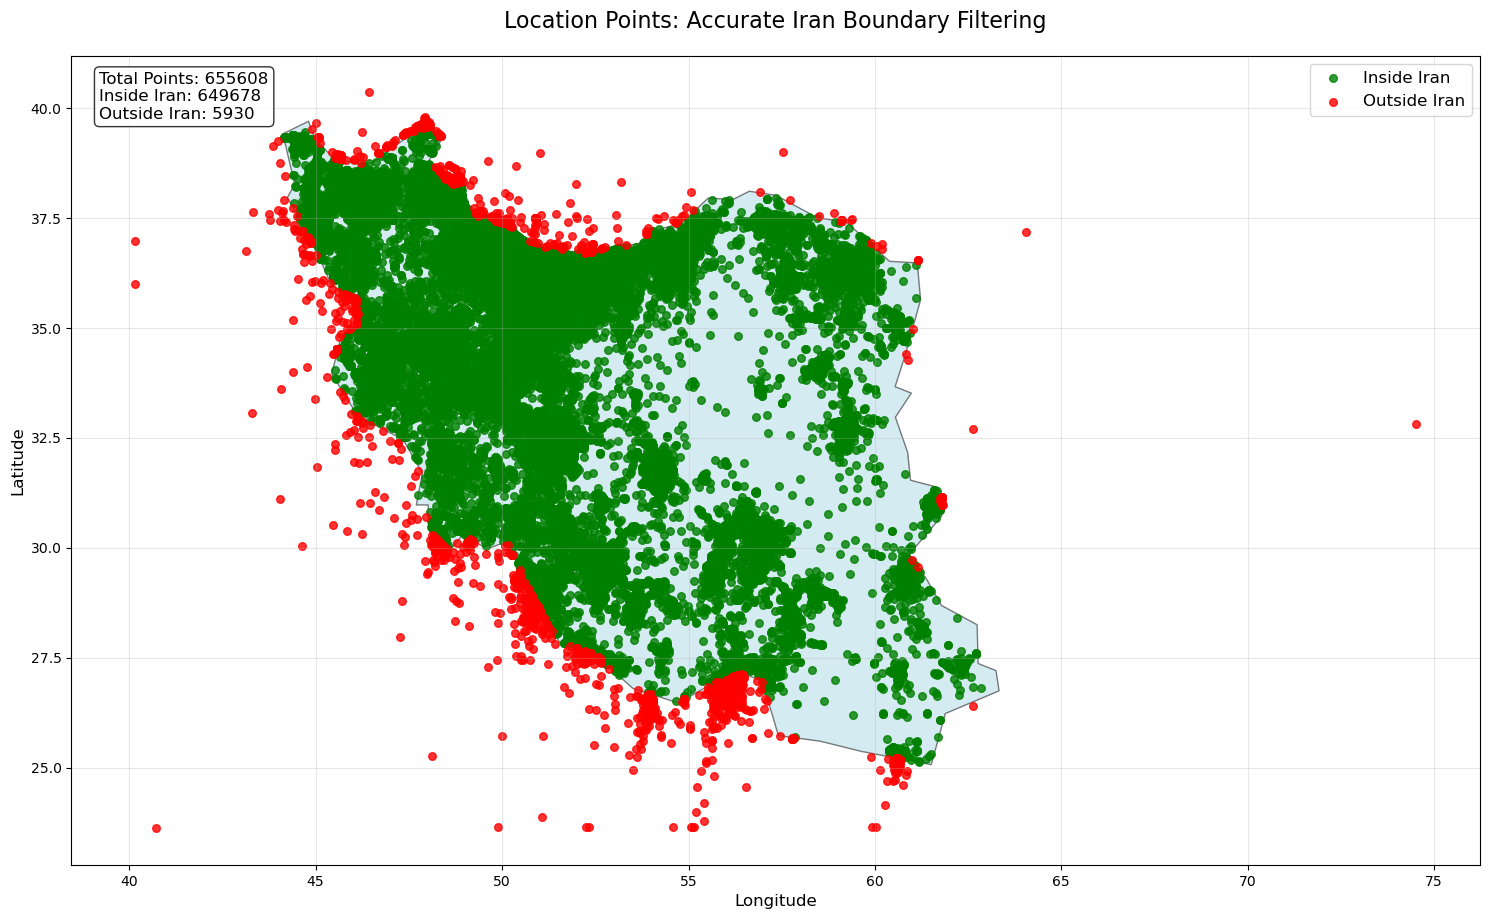

Filtered DataFrame shape: (649678, 58)


In [70]:
# Convert your DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['location_longitude'], df['location_latitude']),
    crs='EPSG:4326'
)

# Perform spatial join to find points within Iran
points_in_iran = gpd.sjoin(gdf, iran, how='inner', predicate='within')
points_outside_iran = gdf[~gdf.index.isin(points_in_iran.index)]

# Create visualization
fig, ax = plt.subplots(figsize=(15, 10))

# Plot Iran with detailed boundaries
iran.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5, label='Iran')

# Plot points inside Iran
points_in_iran.plot(ax=ax, color='green', markersize=30, alpha=0.8, label='Inside Iran')

# Plot points outside Iran
points_outside_iran.plot(ax=ax, color='red', markersize=30, alpha=0.8, label='Outside Iran')

# Customize the plot
ax.set_title('Location Points: Accurate Iran Boundary Filtering', fontsize=16, pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(prop={'size': 12})
ax.grid(True, alpha=0.3)

# Add statistics text box
stats_text = f'Total Points: {len(gdf)}\nInside Iran: {len(points_in_iran)}\nOutside Iran: {len(points_outside_iran)}'
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
        fontsize=12)

plt.tight_layout()
plt.show()

# Return the filtered DataFrame (only points inside Iran)
df = points_in_iran[df.columns].copy()
print(f"Filtered DataFrame shape: {df.shape}")

In [71]:
df = points_in_iran[df.columns]
print(f"Filtered DataFrame shape: {df.shape}")
print(f"Removed {len(points_outside_iran)} outliers (points outside Iran)")

Filtered DataFrame shape: (649678, 58)
Removed 5930 outliers (points outside Iran)


No points outside Iran found


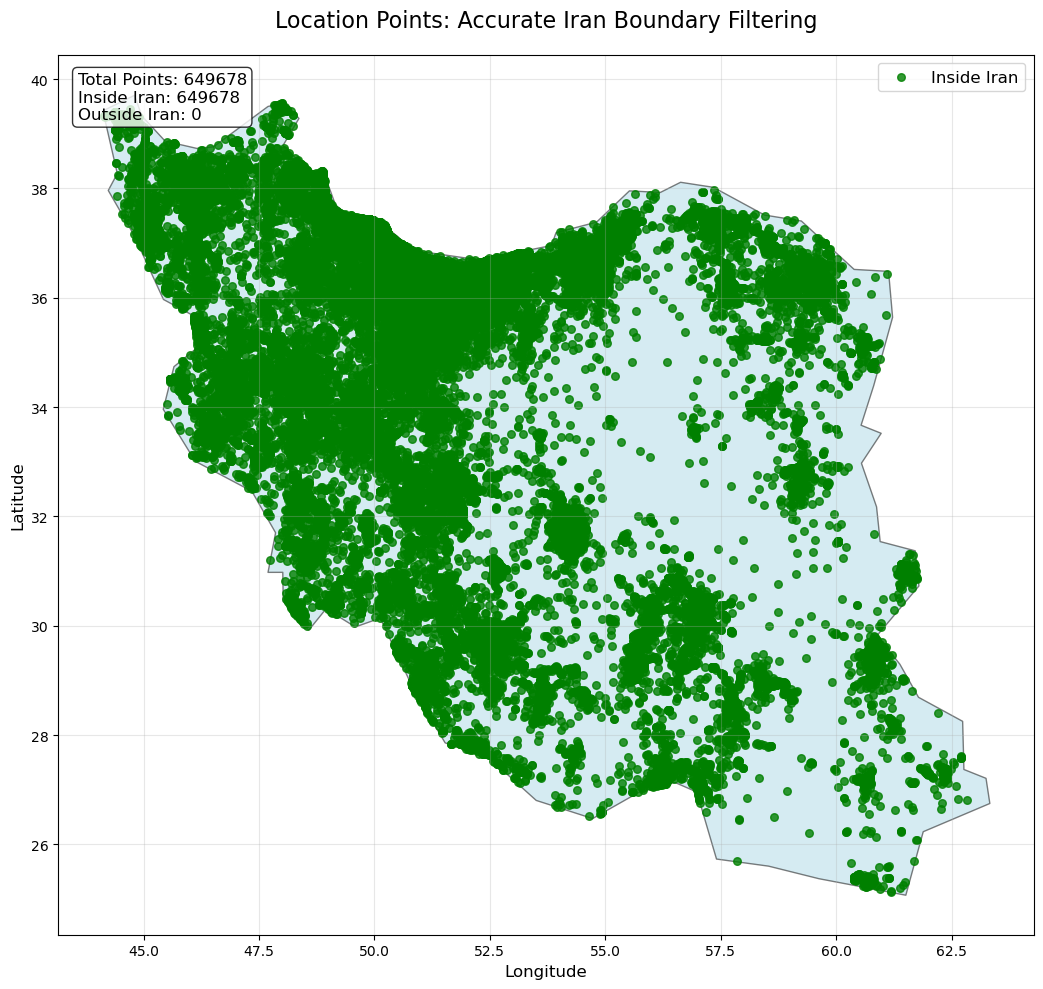

Filtered DataFrame shape: (649678, 58)


In [73]:
# Convert your DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['location_longitude'], df['location_latitude']),
    crs='EPSG:4326'
)

# Perform spatial join to find points within Iran
points_in_iran = gpd.sjoin(gdf, iran, how='inner', predicate='within')
points_outside_iran = gdf[~gdf.index.isin(points_in_iran.index)]

# Create visualization
fig, ax = plt.subplots(figsize=(15, 10))

# Plot Iran with detailed boundaries
iran.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5, label='Iran')

# Plot points inside Iran
points_in_iran.plot(ax=ax, color='green', markersize=30, alpha=0.8, label='Inside Iran')

# Plot points outside Iran only if there are any
if not points_outside_iran.empty:
    points_outside_iran.plot(ax=ax, color='red', markersize=30, alpha=0.8, label='Outside Iran')
else:
    print("No points outside Iran found")

# Customize the plot
ax.set_title('Location Points: Accurate Iran Boundary Filtering', fontsize=16, pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(prop={'size': 12})
ax.grid(True, alpha=0.3)

# Add statistics text box
stats_text = f'Total Points: {len(gdf)}\nInside Iran: {len(points_in_iran)}\nOutside Iran: {len(points_outside_iran)}'
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
        fontsize=12)

plt.tight_layout()
plt.show()

# Return the filtered DataFrame (only points inside Iran)
df_iran = points_in_iran[df.columns].copy()
print(f"Filtered DataFrame shape: {df_iran.shape}")

In [76]:
# Apply outlier detection to price and size columns
outlier_summary = {}

for col in df.columns:
    if col in df.columns and df[col].notna().sum() > 100:
        # Ensure column is numeric
        df[col] = pd.to_numeric(df[col], errors='coerce')

        # Work only with valid numeric data
        valid_data = df[col].dropna()
        if valid_data.empty:
            continue  # skip if nothing usable

        # Detect outliers
        outliers = detect_outliers_multiple_methods(valid_data)
        outlier_count = outliers.sum()
        outlier_percentage = (outlier_count / len(valid_data)) * 100

        # Save summary
        outlier_summary[col] = {
            'count': outlier_count,
            'percentage': outlier_percentage
        }

        # Cap extreme outliers instead of removing them
        if outlier_percentage > 1:  # only if significant
            lower_cap = df[col].quantile(0.01)
            upper_cap = df[col].quantile(0.99)
            df[col] = df[col].clip(lower=lower_cap, upper=upper_cap)

        print(f"  {col}: {outlier_count} outliers ({outlier_percentage:.1f}%) - capped")


  rent_value: 15462 outliers (6.6%) - capped
  price_value: 23309 outliers (6.3%) - capped
  credit_value: 12459 outliers (5.3%) - capped
  rent_credit_transform: 18145 outliers (7.8%) - capped
  transformable_price: 54670 outliers (23.5%) - capped
  transformable_credit: 12459 outliers (5.3%) - capped
  transformed_credit: 3123 outliers (5.7%) - capped
  transformable_rent: 15461 outliers (6.6%) - capped
  transformed_rent: 2869 outliers (5.3%) - capped
  land_size: 7479 outliers (6.6%) - capped
  building_size: 56886 outliers (8.9%) - capped
  has_business_deed: 0 outliers (0.0%) - capped
  floor: 16385 outliers (4.5%) - capped
  rooms_count: 21855 outliers (3.9%) - capped
  total_floors_count: 15892 outliers (7.2%) - capped
  unit_per_floor: 8239 outliers (3.8%) - capped
  has_balcony: 60424 outliers (17.6%) - capped
  has_elevator: 0 outliers (0.0%) - capped
  has_warehouse: 93014 outliers (19.4%) - capped
  has_parking: 118801 outliers (24.8%) - capped
  construction_year: 16685 o

(649678, 58)

# =============================================================================
# STEP 4: MISSING VALUE IMPUTATION
# =============================================================================

In [79]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier


# Features for training (exclude boolean targets except first)
features = df.drop(columns=boolean_columns).copy()

# Encode categorical columns
for col in features.select_dtypes('object').columns:
    features[col] = features[col].astype('category').cat.codes

# Fill numeric NaNs
for col in features.select_dtypes('number').columns:
    features[col] = features[col].fillna(features[col].median())

for target in boolean_columns:
    print(f"\nOptimizing and Filling: {target}")
    
    mask_train = df[target].notna()
    if mask_train.sum() == 0:
        continue

    X_train, y_train = features[mask_train], df.loc[mask_train, target].astype(int)
    
    # Define parameter grid
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 63, 127],
        'max_depth': [6, 8, 10],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    
    # Grid search
    grid_search = GridSearchCV(
        LGBMClassifier(objective='binary', random_state=42, verbose=-1),
        param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV accuracy: {grid_search.best_score_:.4f}")
    
    # Train final model with best parameters
    best_model = grid_search.best_estimator_
    
    # Fill missing values
    mask_missing = df[target].isna()
    if mask_missing.any():
        df.loc[mask_missing, target] = best_model.predict(features[mask_missing])
    
    # Validation accuracy
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    best_model.fit(X_tr, y_tr)
    val_acc = accuracy_score(y_val, best_model.predict(X_val))
    print(f"Validation Accuracy: {val_acc * 100:.2f}%")


Optimizing and Filling: rent_to_single


KeyboardInterrupt: 

In [78]:

# Features for training (exclude boolean targets except first)
features = df.drop(columns=boolean_columns).copy()

# Encode categorical columns
for col in features.select_dtypes('object').columns:
    features[col] = features[col].astype('category').cat.codes

# Fill numeric NaNs
for col in features.select_dtypes('number').columns:
    features[col] = features[col].fillna(features[col].median())

for target in boolean_columns:
    print(f"Filling: {target}")
    mask_train = df[target].notna()
    if mask_train.sum() == 0:
        continue

    X_train, y_train = features[mask_train], df.loc[mask_train, target].astype(int)
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    train_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    model = lgb.train(
        {'objective':'binary','metric':'binary_error','boosting_type':'gbdt',
         'learning_rate':0.06,'num_leaves':31,'verbose':-1,'seed':42},
        train_data, valid_sets=[val_data]
    )

    mask_missing = df[target].isna()
    if mask_missing.any():
        df.loc[mask_missing, target] = (model.predict(features[mask_missing]) > 0.5).astype(int)

    acc = accuracy_score(y_val, (model.predict(X_val) > 0.5).astype(int))
    print(f"Validation Accuracy: {acc * 100:.1f}")


Filling: rent_to_single
Validation Accuracy: 0.0
Filling: has_business_deed
Validation Accuracy: 59.4
Filling: has_balcony
Validation Accuracy: 85.5
Filling: has_elevator
Validation Accuracy: 89.0
Filling: has_electricity
Validation Accuracy: 64.5
Filling: has_gas
Validation Accuracy: 65.0
Filling: has_security_guard
Validation Accuracy: 81.9
Filling: has_warehouse
Validation Accuracy: 82.2
Filling: has_parking
Validation Accuracy: 83.2
Filling: is_rebuilt
Validation Accuracy: 74.3
Filling: has_water
Validation Accuracy: 66.1
Filling: has_barbecue
Validation Accuracy: 78.7
Filling: has_pool
Validation Accuracy: 89.8
Filling: has_jacuzzi
Validation Accuracy: 92.7
Filling: has_sauna
Validation Accuracy: 95.5
Filling: rent_credit_transform
Validation Accuracy: 92.3
Filling: transformable_price
Validation Accuracy: 99.9


In [53]:
# Separate columns by missing value percentage for different strategies
missing_analysis = df.isnull().sum() / len(df) * 100
low_missing = missing_analysis[missing_analysis <= 5].index.tolist()
medium_missing = missing_analysis[(missing_analysis > 5) & (missing_analysis <= 30)].index.tolist()
high_missing = missing_analysis[missing_analysis > 30].index.tolist()

print(f"Low missing (<5%): {len(low_missing)} columns")
print(f"Medium missing (5-30%): {len(medium_missing)} columns")
print(f"High missing (>30%): {len(high_missing)} columns")


Low missing (<5%): 22 columns
Medium missing (5-30%): 2 columns
High missing (>30%): 31 columns


In [54]:
# Check missing values for all columns
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Create missing values summary
missing_summary = pd.DataFrame({
    'missing_count': missing_values,
    'missing_percentage': missing_percentage.round(2)
})

# Show columns with missing values
columns_with_missing = missing_summary[missing_summary['missing_count'] > 0]
print("Columns with missing values:")
print(columns_with_missing.sort_values('missing_percentage', ascending=False))

# Show columns without missing values
columns_without_missing = missing_summary[missing_summary['missing_count'] == 0]
print(f"\nColumns without missing values: {len(columns_without_missing)}")

# Total summary
print(f"\nTotal columns: {len(df.columns)}")
print(f"Columns with missing values: {len(columns_with_missing)}")
print(f"Columns without missing values: {len(columns_without_missing)}")
print(f"Overall missing percentage: {df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100:.2f}%")

Columns with missing values:
                            missing_count  missing_percentage
cost_per_extra_person              989759               98.98
rent_price_on_special_days         989537               98.95
rent_price_at_weekends             986449               98.64
rent_price_on_regular_days         981932               98.19
extra_person_capacity              975991               97.60
property_type                      972943               97.29
regular_person_capacity            970130               97.01
transformed_rent                   927591               92.76
transformed_credit                 927591               92.76
rent_type                          896039               89.60
land_size                          813604               81.36
deed_type                          746542               74.65
user_type                          711118               71.11
unit_per_floor                     697717               69.77
total_floors_count                 695648

In [55]:
# Strategy 1: Simple imputation for low missing
# Impute low missing numerical columns
continus_numeric = price_columns + size_columns

all_numric  = df.select_dtypes(include=['number']).columns.tolist()
for col in low_missing:
    if col in all_numric:
        if col in continus_numeric:  # Continuous price-like columns
            # Use median for price columns (robust to outliers)
            imputer = SimpleImputer(strategy='median')
            df[col] = imputer.fit_transform(df[[col]]).ravel()
            print(f"Imputed {col} with median: {imputer.statistics_[0]:.2f}")
        else:
            # Use mean for other numerical columns
            imputer = SimpleImputer(strategy='mean')
            df[col] = imputer.fit_transform(df[[col]]).ravel()
            print(f"Imputed {col} with mean: {imputer.statistics_[0]:.2f}")

    elif col in categorical_columns:
        # Use mode for categorical columns
        imputer = SimpleImputer(strategy='most_frequent')
        df[col] = imputer.fit_transform(df[[col]]).ravel()
        print(f"Imputed {col} with mode: {imputer.statistics_[0]}")

Imputed cat3_slug with mode: apartment-sell
Imputed city_slug with mode: tehran
Imputed rent_to_single with mean: 1.00
Imputed rent_credit_transform with mean: 0.15
Imputed transformable_price with median: 0.00
Imputed building_size with median: 103.00
Imputed has_business_deed with mean: 0.48
Imputed has_balcony with mean: 0.83
Imputed has_elevator with mean: 0.60
Imputed has_warehouse with mean: 0.78
Imputed has_parking with mean: 0.74
Imputed is_rebuilt with mean: 0.40
Imputed has_water with mean: 0.35
Imputed has_electricity with mean: 0.35
Imputed has_gas with mean: 0.34
Imputed has_security_guard with mean: 0.29
Imputed has_barbecue with mean: 0.29
Imputed has_pool with mean: 0.29
Imputed has_jacuzzi with mean: 0.29
Imputed has_sauna with mean: 0.29


In [ ]:
# # Strategy 2: KNN imputation for medium missing numerical columns
# medium_numerical = [col for col in medium_missing if col in df.select_dtypes(include=[np.number]).columns]
# if medium_numerical:
#     print(f"Applying KNN imputation to {len(medium_numerical)} numerical columns...")
#     knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
#     df[medium_numerical] = knn_imputer.fit_transform(df[medium_numerical])

# =============================================================================
# STEP :  CATEGORICAL ENCODING
# =============================================================================

In [56]:

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Target encoding for high-cardinality location columns (if target available)
high_card_cols = ['city_slug', 'neighborhood_slug']
target_col = 'transformable_price'  # Primary target
if target_col in df.columns:
    for col in high_card_cols:
        if col in df.columns and col in categorical_cols:
            # Calculate mean target value for each category
            target_mean = df.groupby(col)[target_col].mean()
            global_mean = df[target_col].mean()

            # Add smoothing to prevent overfitting
            category_counts = df[col].value_counts()
            smoothing = 100  # Smoothing parameter
            smoothed_means = (target_mean * category_counts + global_mean * smoothing) / (category_counts + smoothing)

            df[f'{col}_target_encoded'] = df[col].map(smoothed_means).fillna(global_mean).astype('float32')
            categorical_cols.remove(col) if col in categorical_cols else None


# Label encoding for remaining categorical columns
label_encoders = {}
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        # Handle missing values
        df[col] = df[col].astype(str).fillna('Unknown')
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

        # Convert to appropriate integer type
        if len(le.classes_) < 128:
            df[col] = df[col].astype('Int8')
        elif len(le.classes_) < 32768:
            df[col] = df[col].astype('Int16')

print(f"Encoded {len(categorical_cols)} categorical columns")

Encoded 16 categorical columns


In [57]:
# Check for remaining object columns
object_cols = df.select_dtypes(include=['object']).columns.tolist()

if object_cols:
    print("Object columns remaining:", object_cols)
    print("Number of object columns:", len(object_cols))
else:
    print("No object columns left - all data is numeric")

Object columns remaining: ['city_slug', 'neighborhood_slug']
Number of object columns: 2


In [58]:
# Label encode high cardinality columns but keep missing values as NaN
high_card_cols = ['city_slug', 'neighborhood_slug']

for col in high_card_cols:
    # Create temporary copy without missing values for fitting
    non_null_mask = df[col].notna()
    non_null_values = df.loc[non_null_mask, col]

    # Fit LabelEncoder on non-null values only
    le = LabelEncoder()
    le.fit(non_null_values.astype(str))

    # Transform only non-null values, keep missing as NaN
    df.loc[non_null_mask, col] = le.transform(non_null_values.astype(str))

    # Convert to appropriate integer type
    unique_count = len(le.classes_)
    if unique_count < 128:
        df[col] = df[col].astype('Int8')
    elif unique_count < 32768:
        df[col] = df[col].astype('Int16')
    else:
        df[col] = df[col].astype('Int32')

In [60]:
# Strategy 4: Handle high missing columns

usable_features = [c for c in df.columns if df[c].isnull().mean() < 0.2]

for col in high_missing:
    print(f"\n⚠️ Processing high missing column: {col}")
    missing_mask = df[col].isnull()
    complete_data = df.loc[~missing_mask]

    # Fallback if too few samples
    if len(complete_data) < 50:
        print(f"Very few complete samples ({len(complete_data)}), using simple imputation")
        if col in categorical_columns or col in boolean_columns:
            fill_val = complete_data[col].mode().iloc[0] if len(complete_data) > 0 else df[col].mode().iloc[0]
        else:
            fill_val = complete_data[col].median() if len(complete_data) > 0 else df[col].median()
        df.loc[missing_mask, col] = fill_val
        continue

    # Select features excluding target col
    features = [c for c in usable_features if c != col]
    if not features:
        print(f"⚠️ No usable features for {col}, falling back to simple imputation")
        if col in categorical_columns or col in boolean_columns:
            fill_val = complete_data[col].mode().iloc[0]
        else:
            fill_val = complete_data[col].median()
        df.loc[missing_mask, col] = fill_val
        continue

    X = complete_data[features]
    y = complete_data[col]

    # Downsample if dataset is too large
    if len(X) > 10000:
        complete_data = complete_data.sample(10000, random_state=42)
        X = complete_data[features]
        y = complete_data[col]

    # Train-test split (lighter than CV)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Categorical / Boolean Columns → Classifier
    if col in categorical_columns or col in boolean_columns:
        model = RandomForestClassifier(n_estimators=30, max_depth=8, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        acc = accuracy_score(y_test, model.predict(X_test))
        print(f"Accuracy: {acc:.3f}")

        if acc >= 0.7 and missing_mask.any():
            to_impute = df.loc[missing_mask, features]
            if not to_impute.empty:
                df.loc[missing_mask, col] = model.predict(to_impute)
                print(f"✅ Imputed {col} with accuracy: {acc:.3f}")
            else:
                print(f"⚠️ No missing rows left to impute for {col}")
        else:
            fill_val = y.mode().iloc[0]
            df.loc[missing_mask, col] = fill_val
            print(f"Used mode fallback: {fill_val}")

    # Numerical Columns → Regressor
    else:
        model = RandomForestRegressor(n_estimators=30, max_depth=8, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        r2 = r2_score(y_test, model.predict(X_test))
        print(f"R2: {r2:.3f}")

        if r2 >= 0.6 and missing_mask.any():
            to_impute = df.loc[missing_mask, features]
            if not to_impute.empty:
                df.loc[missing_mask, col] = model.predict(to_impute)
                print(f"✅ Imputed {col} with R2: {r2:.3f}")
            else:
                print(f"⚠️ No missing rows left to impute for {col}")
        else:
            fill_val = y.median()
            df.loc[missing_mask, col] = fill_val
            print(f"Used median fallback: {fill_val:.2f}")



⚠️ Processing high missing column: neighborhood_slug
Accuracy: 0.597
Used mode fallback: 275

⚠️ Processing high missing column: user_type
Accuracy: 0.977
Used mode fallback: 1

⚠️ Processing high missing column: rent_mode
Accuracy: 0.999
Used mode fallback: 2

⚠️ Processing high missing column: rent_value
R2: 1.000
Used median fallback: 5000000.00

⚠️ Processing high missing column: rent_type
R2: 0.992
Used median fallback: 1.00

⚠️ Processing high missing column: price_mode
R2: 0.996
Used median fallback: 0.00

⚠️ Processing high missing column: price_value
R2: 0.464
Used median fallback: 2850000000.00

⚠️ Processing high missing column: credit_mode
R2: 0.998
Used median fallback: 2.00

⚠️ Processing high missing column: credit_value
R2: 0.938
Used median fallback: 555775947.72

⚠️ Processing high missing column: transformable_credit
R2: 0.994
Used median fallback: 250000000.00

⚠️ Processing high missing column: transformed_credit
R2: 0.894
Used median fallback: 409618957.03

⚠️ Pr

# =============================================================================
# STEP 5:  FEATURE ENGINEERING
# =============================================================================

In [61]:
# Time-based features from Persian date
if 'created_at_month' in df.columns:
    df['created_at_month'] = pd.to_datetime(
        df['created_at_month'], errors='coerce')

    # Convert to JalaliDate and extract month directly
    df['shamsi_date'] = df['created_at_month'].apply(
        lambda x: JalaliDate(x) if pd.notna(x) else None)


    df['month_created'] = df['shamsi_date'].apply(
        lambda x: x.month if x is not None else None

    ).astype('Int8')

    df['year_created'] = df['shamsi_date'].apply(
        lambda x: x.year if x is not None else None
    ).astype('Int16')

    # Create season from month
    df['season_created'] = ((df['month_created'] - 1) // 3 + 1).astype('Int8')


    df.drop('created_at_month', axis=1, inplace=True)

In [66]:
if 'construction_year' in df.columns:
    current_year = 1403  # Current Shamsi year

    # --- Building age ---
    df['building_age'] = (current_year - df['construction_year']).clip(lower=0, upper=100)
    df['building_age'] = df['building_age'].round()  # ensure integer values
    df['building_age'] = df['building_age'].where(df['building_age'].notna(), pd.NA).astype('Int16')

    # --- Age categories ---
    df['age_category'] = pd.cut(
        df['building_age'].fillna(-1),   # temporarily fill NaN
        bins=[-2, 0, 2, 5, 9, 15, 100], # -1 → goes into "Unknown"
        labels=['Unknown', 'New', 'Modern', 'Mature', 'Old', 'Very_Old']
    ).astype(str)

    # --- Condition score ---
    conditions = [
        df['building_age'].between(0, 2, inclusive="both"),
        df['building_age'].between(3, 5, inclusive="both"),
        df['building_age'].between(6, 9, inclusive="both"),
        df['building_age'].between(10, 50, inclusive="both"),
        df['building_age'] > 50
    ]
    choices = [5, 4, 3, 2, 1]
    df['condition_score'] = np.select(conditions, choices, default=pd.NA)
    df['condition_score'] = df['condition_score'].astype('Int8')

    # --- Drop original ---
    df.drop('construction_year', axis=1, inplace=True, errors='ignore')

    # --- Encode categories ---
    age_category_mapping = {
        'Unknown': 0,
        'New': 5,
        'Modern': 4,
        'Mature': 3,
        'Old': 2,
        'Very_Old': 1
    }
    df['age_category_encoded'] = df['age_category'].map(age_category_mapping)
    df['age_category_encoded'] = df['age_category_encoded'].where(
        df['age_category_encoded'].notna(), pd.NA
    ).astype('Int8')

    df.drop('age_category', axis=1, inplace=True, errors='ignore')

In [67]:
# Size and space utilization features
if all(col in df.columns for col in ['building_size', 'land_size']):
    df['building_to_land_ratio'] = (df['building_size'] / (df['land_size'] + 1)).clip(0, 1).astype('float32')
    df['unused_land'] = (df['land_size'] - df['building_size']).clip(0).astype('float32')

In [68]:
if all(col in df.columns for col in ['rooms_count', 'building_size']):
    df['room_size_avg'] = (df['building_size'] / (df['rooms_count'] + 1)).astype('float32')
    df['room_density'] = (df['rooms_count'] / (df['building_size'] + 1)).astype('float32')

In [69]:
# Floor and position features
if all(col in df.columns for col in ['floor', 'total_floors_count']):
    df['floor_ratio'] = (df['floor'] / (df['total_floors_count'] + 1)).clip(0, 1).astype('float32')
    df['is_ground_floor'] = (df['floor'] == 0).astype('int8')
    df['is_top_floor'] = (df['floor'] == df['total_floors_count']).astype('int8')
    df['is_middle_floor'] = ((df['floor'] > 0) & (df['floor'] < df['total_floors_count'])).astype('int8')

In [70]:
# Price efficiency metrics
for price_col in ['transformable_price', 'price_value']:
    if price_col in df.columns and 'building_size' in df.columns:
        df[f'{price_col}_per_sqm'] = (df[price_col] / (df['building_size'] + 1)).astype('float32')

In [71]:
for rent_col in ['transformable_rent', 'rent_value']:
    if rent_col in df.columns and 'building_size' in df.columns:
        df[f'{rent_col}_per_sqm'] = (df[rent_col] / (df['building_size'] + 1)).astype('float32')

In [72]:
# Rental yield calculation (if both price and rent available)
if all(col in df.columns for col in ['transformable_price', 'transformable_rent']):
    df['rental_yield'] = (df['transformable_rent'] * 12 / (df['transformable_price'] + 1) * 100).clip(0, 50).astype('float32')


In [73]:
# Amenities scoring system
luxury_amenities = ['has_pool', 'has_jacuzzi', 'has_sauna', 'has_barbecue']
comfort_amenities = ['has_elevator', 'has_parking', 'has_balcony', 'has_warehouse']
basic_amenities = ['has_water', 'has_gas', 'has_electricity']
security_amenities = ['has_security_guard']

In [74]:
for amenity_group, name in [(luxury_amenities, 'luxury'),
                           (comfort_amenities, 'comfort'),
                           (basic_amenities, 'basic'),
                           (security_amenities, 'security')]:
    available_amenities = [col for col in amenity_group if col in df.columns]
    if available_amenities:
        df[f'{name}_score'] = df[available_amenities].sum(axis=1).astype('int8')


In [75]:
# Total amenities score with weights
amenity_weights = {'luxury_score': 3, 'comfort_score': 2, 'basic_score': 1, 'security_score': 2}
df['total_amenity_score'] = 0
for score_col, weight in amenity_weights.items():
    if score_col in df.columns:
        df['total_amenity_score'] += df[score_col] * weight
df['total_amenity_score'] = df['total_amenity_score'].astype('Int8')


In [76]:
# Location desirability (based on neighborhood price statistics)
if 'neighborhood_slug' in df.columns and 'transformable_price' in df.columns:
    neighborhood_stats = df.groupby('neighborhood_slug')['transformable_price'].agg(['mean', 'median', 'count'])
    neighborhood_stats['price_rank'] = neighborhood_stats['median'].rank(pct=True)
    df = df.merge(neighborhood_stats[['price_rank']].reset_index(), on='neighborhood_slug', how='left')
    df['neighborhood_desirability'] = (df['price_rank'] * 5).round().astype('int8')
    df.drop('price_rank', axis=1, inplace=True)

In [77]:
# Market segment classification
if 'transformable_price' in df.columns:
    # Ensure numeric
    df['transformable_price'] = pd.to_numeric(df['transformable_price'], errors='coerce')

    # Drop NaNs for quantile calculation
    valid_prices = df['transformable_price'].dropna()
    if not valid_prices.empty:
        price_quartiles = valid_prices.quantile([0.25, 0.5, 0.75])

        # Define bins safely
        bins = [0] + price_quartiles.tolist() + [float('inf')]

        # Ensure bins are strictly increasing
        bins = sorted(set(bins))

        # Create labels dynamically
        labels = ['Budget', 'Mid_Range', 'Premium', 'Luxury'][:len(bins)-1]

        df['market_segment'] = pd.cut(
            df['transformable_price'],
            bins=bins,
            labels=labels,
            duplicates='drop'   # handle duplicate edges safely
        ).astype(str)


In [ ]:
# Set up UTM projection for Iran (Zone 39N covers most of Iran)
transformer = pyproj.Transformer.from_crs('EPSG:4326', 'EPSG:32639', always_xy=True)

utm_coords = []
for idx, row in df_clustering.iterrows():
    try:
        # Transform longitude, latitude to UTM x, y
        x, y = transformer.transform(row['location_longitude'], row['location_latitude'])
        utm_coords.append([x, y])
    except Exception as e:
        # In case of transformation error, use NaN
        utm_coords.append([np.nan, np.nan])

# Convert to numpy array and add to dataframe
utm_coords = np.array(utm_coords)
df_clustering['utm_x'] = utm_coords[:, 0]
df_clustering['utm_y'] = utm_coords[:, 1]

# Remove rows with invalid UTM coordinates
df_clustering = df_clustering.dropna(subset=['utm_x', 'utm_y'])

# Remove original lat/lon columns for clustering (we'll use UTM instead)
df_clustering = df_clustering.drop(['location_latitude', 'location_longitude'], axis=1)

print(f"Dataset shape after UTM conversion: {df_clustering.shape}")

# =============================================================================
# STEP 7: FEATURE SCALING AND NORMALIZATION
# =============================================================================

In [78]:
# Identify numerical columns for scaling
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
price_cols_in_df = [col for col in price_columns if col in numerical_cols]
size_cols_in_df = [col for col in size_columns if col in numerical_cols]

In [79]:
# Different scaling strategies for different types of features
scalers = {}

# Log transformation for highly skewed price data
for col in price_cols_in_df:
    if df[col].min() > 0:  # Ensure all values are positive
        df[f'{col}_log'] = np.log1p(df[col]).astype('float32')

In [80]:
# Power transformation for moderately skewed data
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
skewed_cols = []
for col in numerical_cols:
    if col not in price_cols_in_df and df[col].dtype in ['float32', 'float64']:
        skewness = abs(df[col].skew())
        if skewness > 1:  # Moderately skewed
            skewed_cols.append(col)

if skewed_cols:
    df_skewed_transformed = power_transformer.fit_transform(df[skewed_cols])
    for i, col in enumerate(skewed_cols):
        df[f'{col}_transformed'] = df_skewed_transformed[:, i].astype('float32')
    scalers['power_transformer'] = power_transformer

In [81]:
# Robust scaling for price and size features (resistant to outliers)
robust_scaler = RobustScaler()
robust_cols = price_cols_in_df + size_cols_in_df + [col for col in numerical_cols if 'per_sqm' in col]
robust_cols = [col for col in robust_cols if col in df.columns]

if robust_cols:
    df_robust_scaled = robust_scaler.fit_transform(df[robust_cols])
    for i, col in enumerate(robust_cols):
        df[f'{col}_robust_scaled'] = df_robust_scaled[:, i].astype('float32')
    scalers['robust_scaler'] = robust_scaler

In [82]:
# Standard scaling for normally distributed features
normal_cols = [col for col in numerical_cols
               if col not in robust_cols and col not in skewed_cols
               and col not in price_cols_in_df
               and df[col].dtype in ['float32', 'float64']
               and abs(df[col].skew()) <= 1]

if normal_cols:
    standard_scaler = StandardScaler()
    df_standard_scaled = standard_scaler.fit_transform(df[normal_cols])
    for i, col in enumerate(normal_cols):
        df[f'{col}_standard_scaled'] = df_standard_scaled[:, i].astype('float32')
    scalers['standard_scaler'] = standard_scaler

print(f"Applied scaling to {len(robust_cols + normal_cols + skewed_cols)} numerical features")

Applied scaling to 53 numerical features



# =============================================================================
# STEP 8: FEATURE SELECTION AND DIMENSIONALITY REDUCTION
# =============================================================================

In [84]:

# Only numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Compute correlation matrix
corr_matrix = df[numerical_features].corr().abs()

# Select the upper triangle (no duplicate pairs)
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find top 15 highest correlations
top_corr = upper_triangle.stack().sort_values(ascending=False).head(15)
print("Top 15 highly correlated feature pairs:\n")
print(top_corr)

# Optional: visualize as a heatmap
top_features = list(set([i for pair in top_corr.index for i in pair]))  # unique features from top pairs

Top 15 highly correlated feature pairs:

transformed_credit          transformed_credit_log               0.845734
building_size_transformed   room_size_avg_transformed            0.842323
building_to_land_ratio      building_size_transformed            0.808623
rent_mode                   price_mode                           0.802896
land_size                   unused_land                          0.788736
credit_value_log            transformable_credit_log             0.783393
transformable_price         transformable_price_per_sqm          0.776643
total_floors_count          total_floors_count_transformed       0.771260
has_parking                 comfort_score                        0.754243
credit_value                transformed_credit_log               0.749136
floor                       floor_ratio                          0.742707
extra_person_capacity       extra_person_capacity_transformed    0.740828
credit_value                credit_value_log                     0.7368

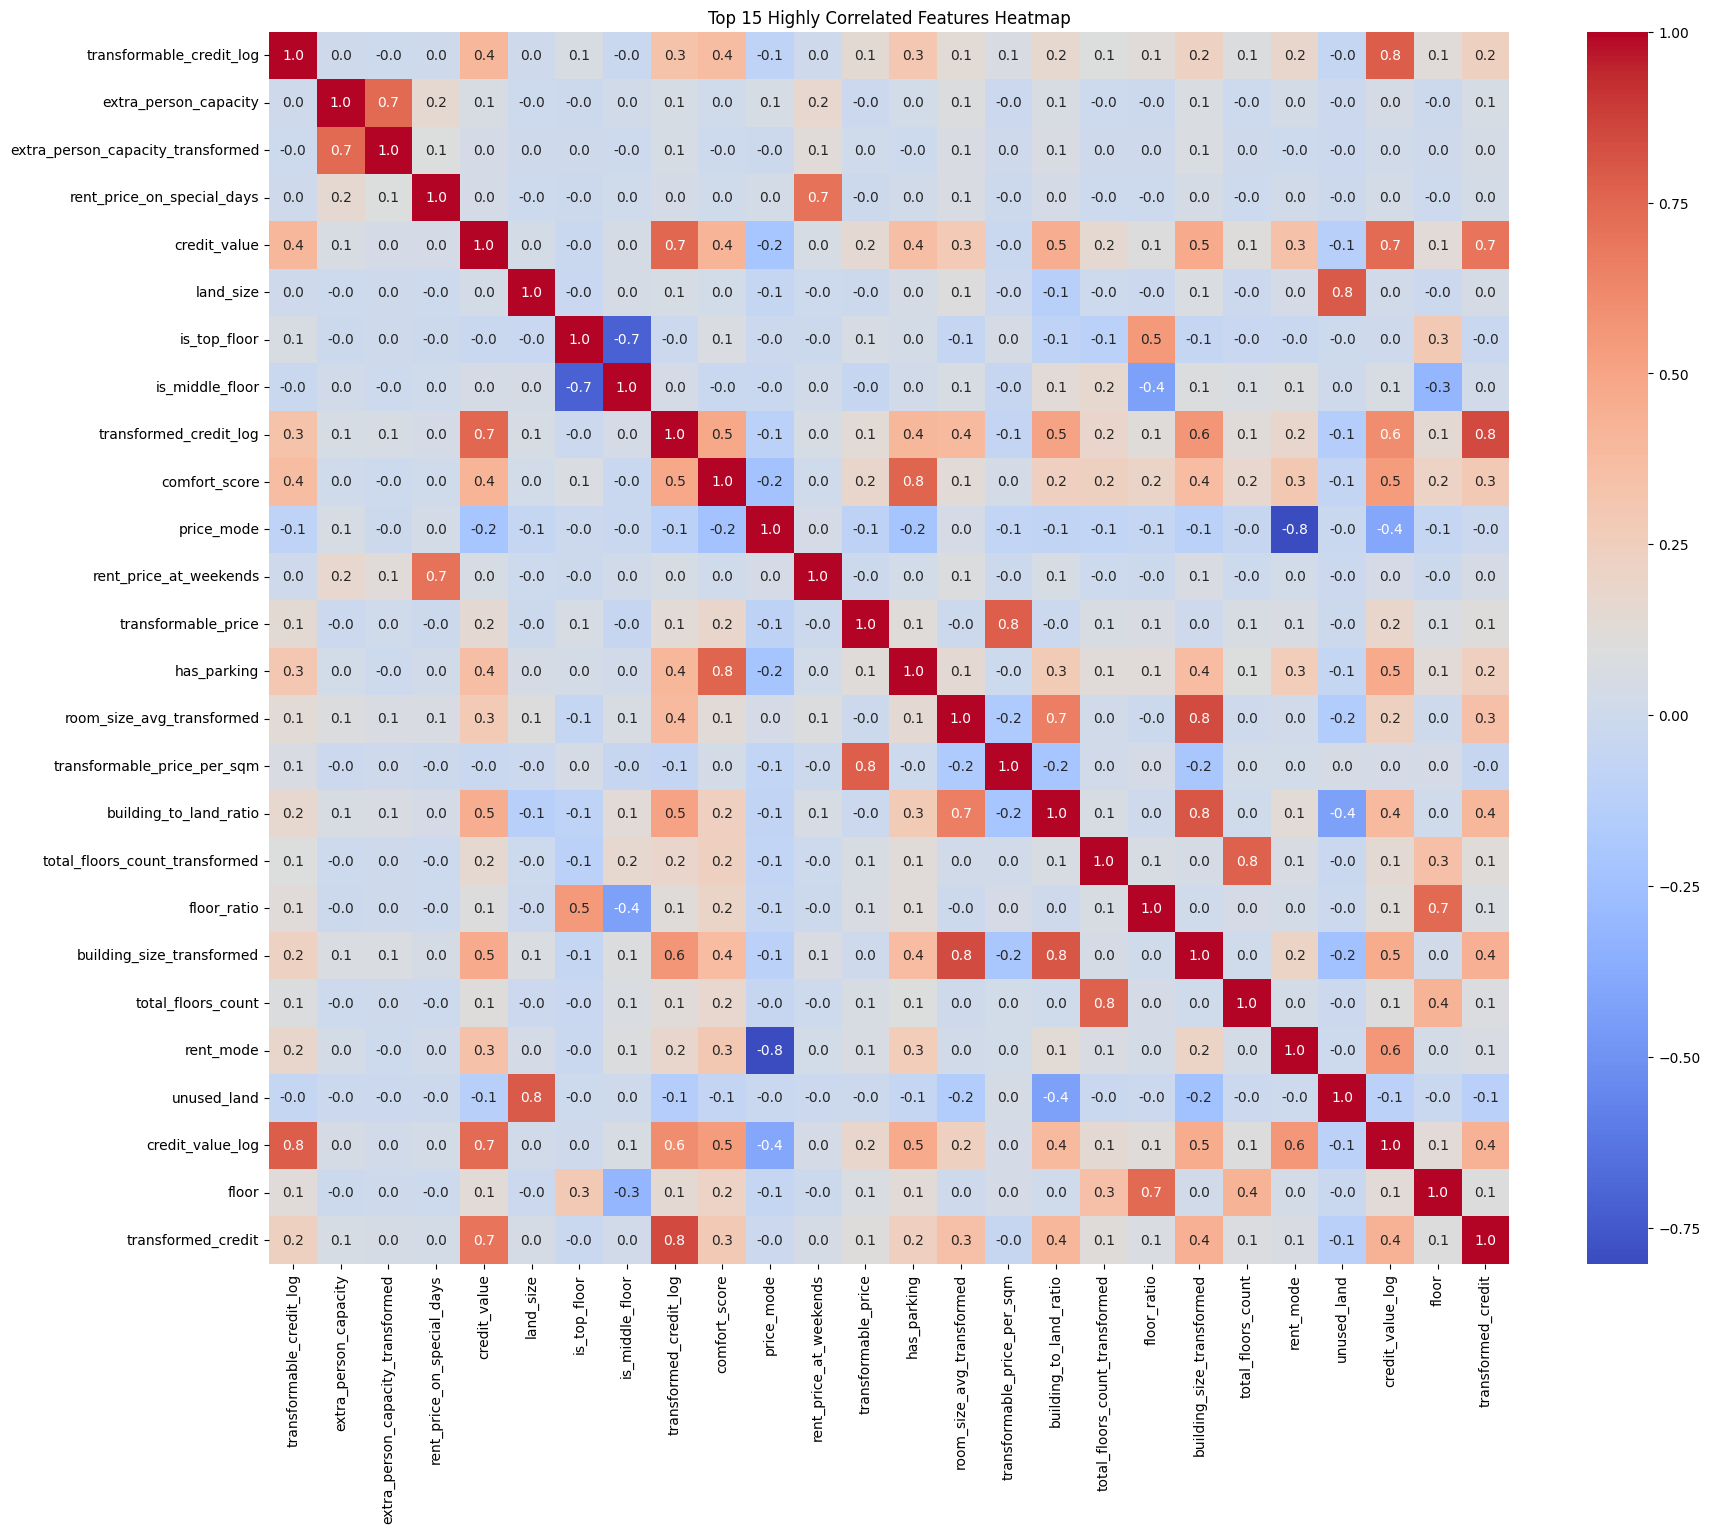

In [91]:

#visualize as a heatmap
top_features = list(set([i for pair in top_corr.index for i in pair]))  # unique features from top pairs

plt.figure(figsize=(20, 16))
sns.heatmap(df[top_features].corr(), annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Top 15 Highly Correlated Features Heatmap")
plt.show()

In [83]:
# # Remove highly correlated features to reduce multicollinearity
# correlation_threshold = 0.85
# numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

# if len(numerical_features) > 1:
#     corr_matrix = df[numerical_features].corr().abs()
#     upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

#     # Find highly correlated feature pairs
#     high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j])
#                        for i in range(len(corr_matrix.index))
#                        for j in range(len(corr_matrix.columns))
#                        if upper_triangle.iloc[i, j] > correlation_threshold]

#     # Remove features with high correlation (keep the first one in each pair)
#     features_to_drop = []
#     for feature1, feature2 in high_corr_pairs:
#         if feature2 not in features_to_drop:
#             features_to_drop.append(feature2)

#     if features_to_drop:
#         df.drop(columns=features_to_drop, inplace=True)
#         print(f"Removed {len(features_to_drop)} highly correlated features")

Removed 60 highly correlated features


# =============================================================================
# STEP 9: MEMORY OPTIMIZATION
# =============================================================================

In [92]:
# Optimize data types
for col in df.columns:
    if df[col].dtype == 'float64':
        df[col] = pd.to_numeric(df[col], downcast='float')
    elif df[col].dtype == 'int64':
        df[col] = pd.to_numeric(df[col], downcast='integer')

# Convert low-cardinality object columns to category
for col in df.select_dtypes(include=['object']).columns:
    if df[col].nunique() < len(df) * 0.3:  # Less than 30% unique values
        df[col] = df[col].astype('category')


# =============================================================================
# STEP 10: FINAL VALIDATION AND EXPORT
# =============================================================================

In [96]:
# Check missing values for all columns
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Create missing values summary
missing_summary = pd.DataFrame({
    'missing_count': missing_values,
    'missing_percentage': missing_percentage.round(2)
})

# Show columns with missing values
columns_with_missing = missing_summary[missing_summary['missing_count'] > 0]
print("Columns with missing values:")
print(columns_with_missing.sort_values('missing_percentage', ascending=False))

# Show columns without missing values
columns_without_missing = missing_summary[missing_summary['missing_count'] == 0]
print(f"\nColumns without missing values: {len(columns_without_missing)}")

# Total summary
print(f"\nTotal columns: {len(df.columns)}")
print(f"Columns with missing values: {len(columns_with_missing)}")
print(f"Columns without missing values: {len(columns_without_missing)}")
print(f"Overall missing percentage: {df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100:.2f}%")

Columns with missing values:
Empty DataFrame
Columns: [missing_count, missing_percentage]
Index: []

Columns without missing values: 79

Total columns: 79
Columns with missing values: 0
Columns without missing values: 79
Overall missing percentage: 0.00%


In [99]:
# Export processed data
df.to_csv("clean_divar_data.csv", index=False)
df.to_pickle("clean_divar_data.pkl")

In [97]:
print(f"\nTop Features by Type:")
price_features = [col for col in df.columns if 'price' in col.lower() or 'rent' in col.lower()]
size_features = [col for col in df.columns if 'size' in col.lower() or 'area' in col.lower()]
location_features = [col for col in df.columns if any(x in col.lower() for x in ['city', 'neighborhood', 'location'])]
amenity_features = [col for col in df.columns if 'has_' in col.lower() or 'score' in col.lower()]

print(f"  Price-related: {len(price_features)} features")
print(f"  Size-related: {len(size_features)} features")
print(f"  Location-related: {len(location_features)} features")
print(f"  Amenity-related: {len(amenity_features)} features")


Top Features by Type:
  Price-related: 19 features
  Size-related: 5 features
  Location-related: 9 features
  Amenity-related: 12 features


In [ ]:
print(f"\nReady for Machine Learning:")
print(f"  ✓ No missing values")
print(f"  ✓ Optimized data types")
print(f"  ✓ Scaled numerical features")
print(f"  ✓ Encoded categorical features")
print(f"  ✓ Rich feature set for real estate prediction")
print(f"  ✓ Preprocessing artifacts saved for production use")